In [180]:
from isc_tools import *
import numpy as np
from scipy.stats import ttest_ind
from scipy.interpolate import interp1d

In [181]:
froot = '/data00/layerfMRI/'
datafld = froot + 'Github_repo/layerfMRI/analyses/dual_ISC/TC_4_lorenzo/'

In [182]:
summary_log = import_summary_log(froot)
movie_length = extract_movie_length(summary_log)

sel_JUs = {13:'BA44', 35:'PFt', 200: 'Vis'}


In [183]:
## Parameters corresponding to data to be analyzed
nbins = 6
thr = 100
method = 'M_OR_S'

input_file = datafld + f'{method}_JU_time_courses_thr{thr}_bin{nbins}.csv'

In [184]:
df = import_timecourse_dataframe(
    input_file,
    check_movie_length = True, movie_length = movie_length
)

## Exclude subject 11
df = exclude_subjects(df,['sub_11'])

In [216]:
df['FT'] = df['tc_mean_trimmed'].apply(np.fft.rfft)
df['FTfr'] = df['measured_movl'].apply(np.fft.rfftfreq,d = 4)

In [220]:
df['FTfr'].apply(min).max

<bound method Series.max of 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
34555    0.0
34556    0.0
34557    0.0
34558    0.0
34559    0.0
Name: FTfr, Length: 31104, dtype: float64>

In [242]:
newfreq = np.arange(0.01,0.11,0.01)
newfreq

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ])

<function numpy.fft.fftfreq(n, d=1.0)>

In [244]:
df['FTunif'] = df.apply(lambda d: interp1d(d.FTfr,d.FT)(newfreq), axis=1)

In [259]:
a = (df
     .groupby(['contrast','muvi','run','JU','D_bins'])
     .apply(lambda d : np.average(d['FTunif']))#/np.average(np.abs(d['FTunif'])))
     .reset_index()
    )

In [260]:
freqdf = pd.DataFrame()
for i in range(len(newfreq)):
    ft_data = a.reset_index().drop(0,axis=1)
    ft_data['FT'] = a.reset_index()[0].apply(lambda d : np.abs(d[i]))
    ft_data['freq'] = newfreq[i]
    freqdf = freqdf.append(ft_data)

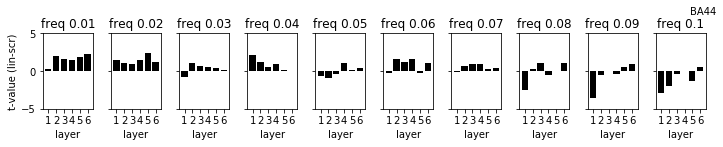

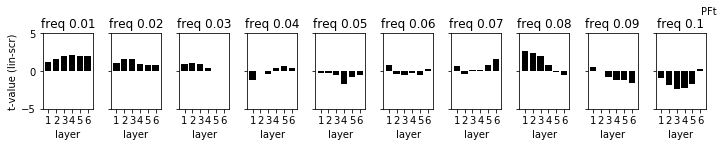

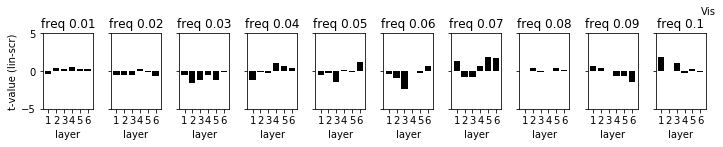

In [261]:
Nbins = 6

for nj in sel_JUs:

    fig,ax = plt.subplots(ncols = len(newfreq), figsize = (10,2), sharey = True)

    for i in range(len(newfreq)):

        for nb in range(1,Nbins+1):

            pdf = freqdf.loc[lambda d : (d['JU']==nj)&(d['D_bins']==nb)&(d['freq']==newfreq[i])]

            t,p = ttest_ind(pdf.loc[lambda d:d['contrast']=='Motion'].FT.values,pdf.loc[lambda d:d['contrast']=='Scrambled'].FT.values)
            ax[i].bar(nb,t,color ='black')
#             if p < 0.05:
#                 ax[i].plot(nb,t*1.2,'k*')
#             mm = np.average(pdf.loc[lambda d:d['contrast']=='Motion'].FT.values)
#             nm = len(pdf.loc[lambda d:d['contrast']=='Motion'])
#             sm = np.std(pdf.loc[lambda d:d['contrast']=='Motion'].FT.values)/np.sqrt(nm)
#             ms = np.average(pdf.loc[lambda d:d['contrast']=='Scrambled'].FT.values)
#             ns = len(pdf.loc[lambda d:d['contrast']=='Scrambled'])
#             ss = np.std(pdf.loc[lambda d:d['contrast']=='Scrambled'].FT.values)/np.sqrt(ns)
            
#             a = mm - ms
#             s = np.sqrt(sm**2+ss**2)
#             ax[i].errorbar([nb],[a],yerr=[s],color = 'black',marker='+')

            ax[i].set_xlabel('layer')
            ax[i].set_title('freq {}'.format(np.round(newfreq[i],3)))
        ax[i].set_xticks([1,2,3,4,5,6])
    ax[0].set_ylabel('t-value (lin-scr)')
    ax[0].set_ylim([-5,5])
    plt.figtext(1,1,sel_JUs[nj],horizontalalignment='right',verticalalignment='top')
    plt.tight_layout()#top=0.75,left=0.1,right=0.9)



In [210]:
ttest_ind([1,2,3,4],[0,1,0,0])

Ttest_indResult(statistic=3.250418033315768, pvalue=0.017457188595772322)

In [38]:
df['tc_mean_trimmed'][0]

array([-0.06742153,  0.30583666, -0.84331577,  2.29175149, -0.0409695 ,
       -1.2294592 , -0.06035995, -0.14840902, -0.27067066,  1.07925055,
        0.64194559, -1.65817865])

In [10]:
from __future__ import division
import pycwt as wavelet
from pycwt.helpers import find
import numpy as np
from matplotlib import pyplot as plt

In [41]:
url = 'http://paos.colorado.edu/research/wavelets/wave_idl/nino3sst.txt'
dat = np.genfromtxt(url, skip_header=19)
title = 'NINO3 Sea Surface Temperature'
label = 'NINO3 SST'
units = 'degC'
t0 = 0
dt = 0.25  # In years

In [40]:
N = dat.size
t = numpy.arange(0, N) * dt + t0

In [14]:
p = np.polyfit(t - t0, dat, 1)
dat_notrend = dat - numpy.polyval(p, t - t0)
std = dat_notrend.std()  # Standard deviation
var = std ** 2  # Variance
dat_norm = dat_notrend / std  # Normalized dataset

In [15]:
mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale, in this case 2 * 0.25 years = 6 months
dj = 1 / 12  # Twelve sub-octaves per octaves
J = 7 / dj  # Seven powers of two with dj sub-octaves
alpha, _, _ = wavelet.ar1(dat)  # Lag-1 autocorrelation for red noise

In [16]:
wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J,
                                                      mother)
iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std

In [17]:
power = (numpy.abs(wave)) ** 2
fft_power = numpy.abs(fft) ** 2
period = 1 / freqs

In [18]:
power /= scales[:, None]

In [19]:
signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
sig95 = numpy.ones([1, N]) * signif[:, None]
sig95 = power / sig95

In [20]:
glbl_power = power.mean(axis=1)
dof = N - scales  # Correction for padding at edges
glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
                                        significance_level=0.95, dof=dof,
                                        wavelet=mother)

In [21]:
sel = find((period >= 2) & (period < 8))
Cdelta = mother.cdelta
scale_avg = (scales * numpy.ones((N, 1))).transpose()
scale_avg = power / scale_avg  # As in Torrence and Compo (1998) equation 24
scale_avg = var * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
scale_avg_signif, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                             significance_level=0.95,
                                             dof=[scales[sel[0]],
                                                  scales[sel[-1]]],
                                             wavelet=mother)

/home/deangelis/anaconda3/envs/brainiak/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


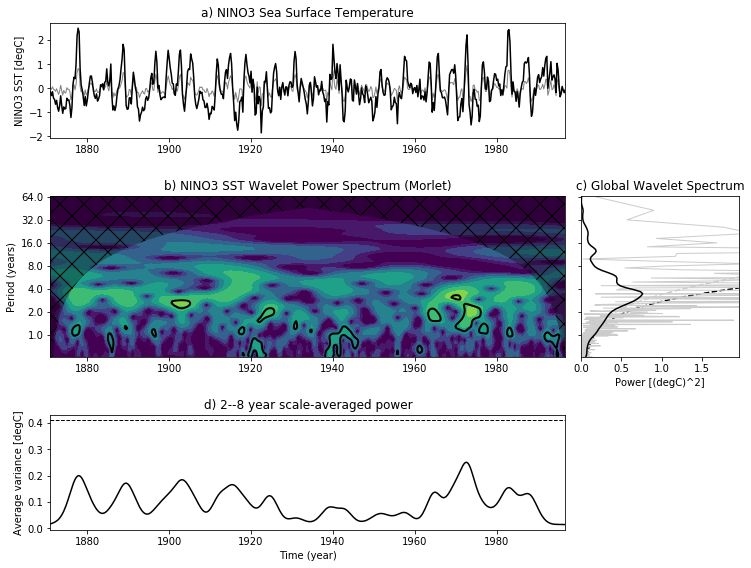

In [22]:
# Prepare the figure
pyplot.close('all')
pyplot.ioff()
figprops = dict(figsize=(11, 8), dpi=72)
fig = pyplot.figure(**figprops)

# First sub-plot, the original time series anomaly and inverse wavelet
# transform.
ax = pyplot.axes([0.1, 0.75, 0.65, 0.2])
ax.plot(t, iwave, '-', linewidth=1, color=[0.5, 0.5, 0.5])
ax.plot(t, dat, 'k', linewidth=1.5)
ax.set_title('a) {}'.format(title))
ax.set_ylabel(r'{} [{}]'.format(label, units))

# Second sub-plot, the normalized wavelet power spectrum and significance
# level contour lines and cone of influece hatched area. Note that period
# scale is logarithmic.
bx = pyplot.axes([0.1, 0.37, 0.65, 0.28], sharex=ax)
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
bx.contourf(t, numpy.log2(period), numpy.log2(power), numpy.log2(levels),
            extend='both', cmap=pyplot.cm.viridis)
extent = [t.min(), t.max(), 0, max(period)]
bx.contour(t, numpy.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
           extent=extent)
bx.fill(numpy.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                           t[:1] - dt, t[:1] - dt]),
        numpy.concatenate([numpy.log2(coi), [1e-9], numpy.log2(period[-1:]),
                           numpy.log2(period[-1:]), [1e-9]]),
        'k', alpha=0.3, hatch='x')
bx.set_title('b) {} Wavelet Power Spectrum ({})'.format(label, mother.name))
bx.set_ylabel('Period (years)')
#
Yticks = 2 ** numpy.arange(numpy.ceil(numpy.log2(period.min())),
                           numpy.ceil(numpy.log2(period.max())))
bx.set_yticks(numpy.log2(Yticks))
bx.set_yticklabels(Yticks)

# Third sub-plot, the global wavelet and Fourier power spectra and theoretical
# noise spectra. Note that period scale is logarithmic.
cx = pyplot.axes([0.77, 0.37, 0.2, 0.28], sharey=bx)
cx.plot(glbl_signif, numpy.log2(period), 'k--')
cx.plot(var * fft_theor, numpy.log2(period), '--', color='#cccccc')
cx.plot(var * fft_power, numpy.log2(1./fftfreqs), '-', color='#cccccc',
        linewidth=1.)
cx.plot(var * glbl_power, numpy.log2(period), 'k-', linewidth=1.5)
cx.set_title('c) Global Wavelet Spectrum')
cx.set_xlabel(r'Power [({})^2]'.format(units))
cx.set_xlim([0, glbl_power.max() + var])
cx.set_ylim(numpy.log2([period.min(), period.max()]))
cx.set_yticks(numpy.log2(Yticks))
cx.set_yticklabels(Yticks)
pyplot.setp(cx.get_yticklabels(), visible=False)

# Fourth sub-plot, the scale averaged wavelet spectrum.
dx = pyplot.axes([0.1, 0.07, 0.65, 0.2], sharex=ax)
dx.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
dx.plot(t, scale_avg, 'k-', linewidth=1.5)
dx.set_title('d) {}--{} year scale-averaged power'.format(2, 8))
dx.set_xlabel('Time (year)')
dx.set_ylabel(r'Average variance [{}]'.format(units))
ax.set_xlim([t.min(), t.max()])

pyplot.show()